### Sandbox used for development and testing

Below, we show how to fully initialize a test simulation. This sandbox was used for model validation and contains intermediate code used for visualizations. For use on a real-world example, please see rvk_auk.ipynb.

Boundary injection CVS file successfully loaded for NB_LD_EV. The time bin is 1.00 min(s).
Boundary injection CVS file successfully loaded for NB_LD_ICE. The time bin is 1.00 min(s).
Minimum road resolution used. There are 53 road segments, each of length 1.89 km.
0.0 0.0 0.0 0.0 0 46.666666666666664
0.0 0.0 0.0 0.0 0 46.666666666666664
0.0 0.0 0.0 0.0 0 46.666666666666664
0.0 0.0 0.0 0.0 0 46.666666666666664
0.0 0.0 0.0 0.0 0 46.666666666666664
0.0 0.0 0.0 0.0 0 46.666666666666664
6.415290187701467 7.472946645224939 13.888236832926406 13.88823683292641 0.461922579869319 46.666666666666664
0.0 0.0 0.0 0.0 0 46.666666666666664
10.2805550593965 12.148947425779651 22.42950248517615 22.429502485176148 0.4583496698685585 46.666666666666664
0.0 0.0 0.0 0.0 0 46.666666666666664
11.9848669094189 13.94655449317964 25.931421402598538 25.931421402598538 0.46217547134604503 46.666666666666664
0.0 0.0 0.0 0.0 0 46.666666666666664
12.76762984441129 14.360280521639897 27.127910366051186 27.1279103660

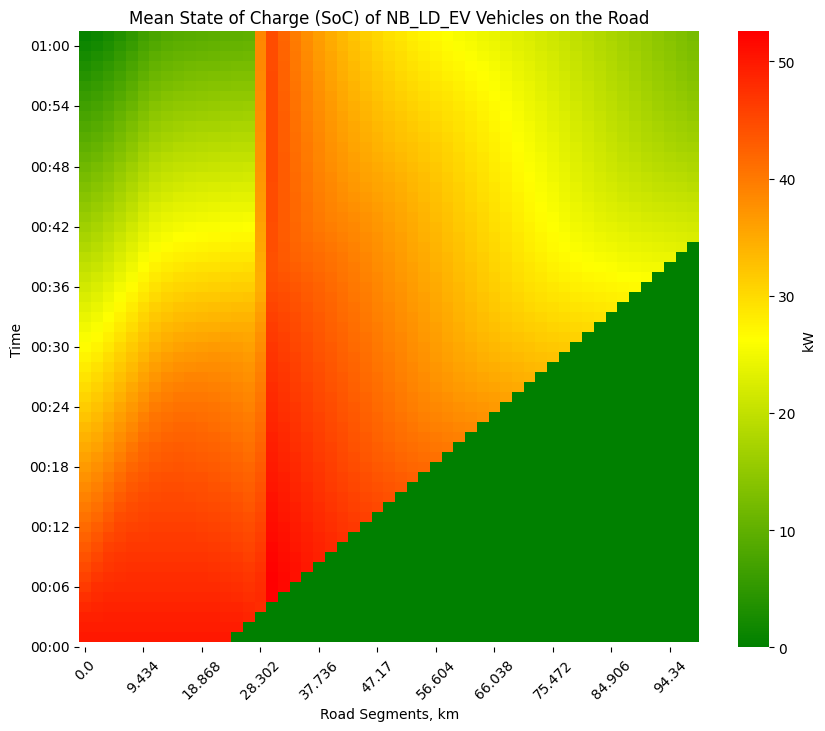

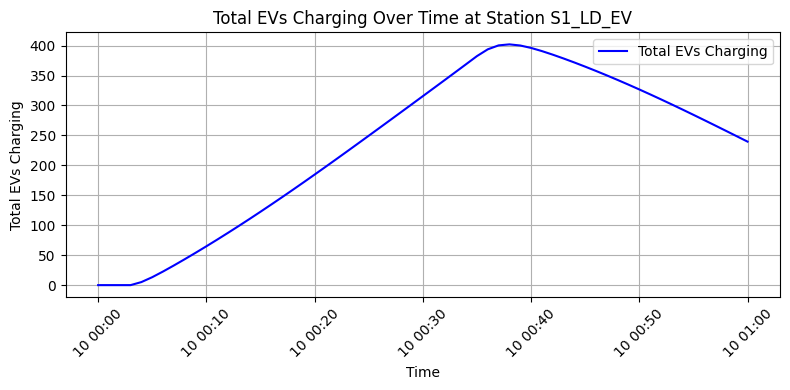

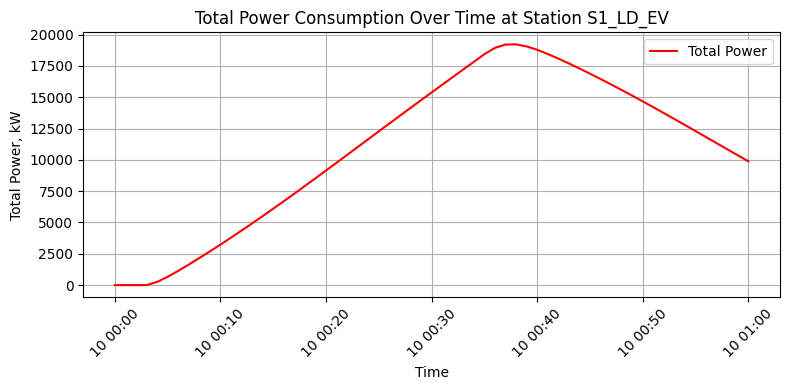

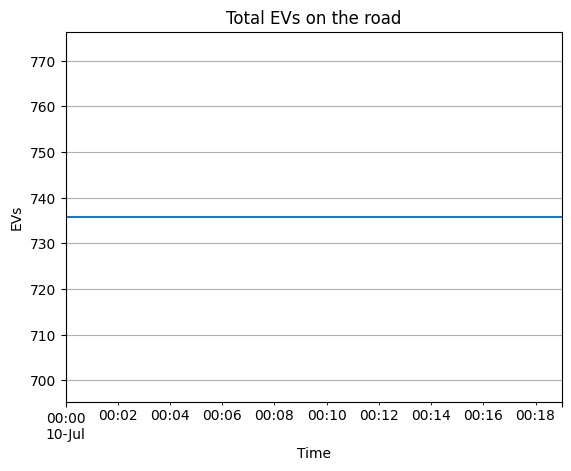

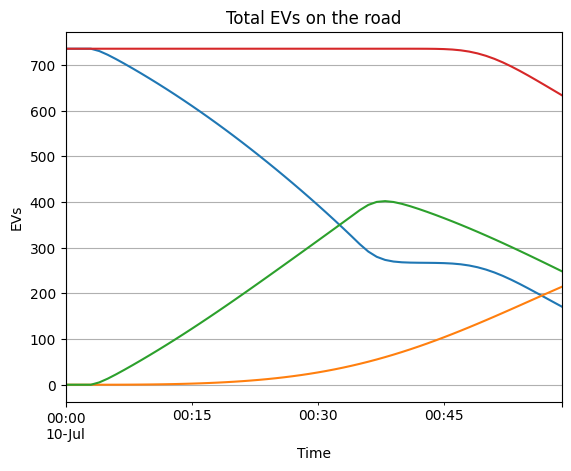

In [9]:
# RECOMMENDED TO RESTART KERNEL EACH TIME
import CTEC

# Initialize the traffic behaviour for all vehicles on the road.
traffic = CTEC.trafficBehaviour(avg_vehicle_length=4.5,
                                avg_vehicle_buffer=3.6,
                                freeflow_speed=90)

# Initialize the type of vehicles to be added to the road
emax = 75
NB_LD_EV = CTEC.vehicleType(battery_capacity=emax,
                         discharge_rate_freeflow=-50 ,#-18,
                         discharge_rate_jam=-5,
                         vehicleType_ID='NB_LD_EV') #-1)

NB_LD_ICE = CTEC.vehicleType(vehicleType_ID = 'NB_LD_ICE')

# Initialize an fast-charging service station
S1_LD_EV = CTEC.stationType(vehicleType=NB_LD_EV,
                            off_ramp_location=30, # km
                            on_ramp_location=40, # km
                            max_charging_rate=50, # kW
                            stationType_ID='S1_LD_EV')

# Initialize the road
x0 = 0; xf = 100
road = CTEC.roadScenario(trafficBehaviour=traffic,
                         road_start=x0,
                         road_end=xf)

road.load_vehicleType(NB_LD_EV, boundary_injection_path='empty.csv')
road.load_vehicleType(vehicleType=NB_LD_ICE, boundary_injection_path='empty.csv')
road.load_stationType(S1_LD_EV)

road.initialize_with_loaded_data()

# ADD IN TEST DISTRIBUTIONS ON THE ROAD
import numpy as np
start_index = road.road_cells // 4  # Start of the second quarter
end_index = road.road_cells // 2  # End of the second quarter
test = np.zeros(road.road_cells)
test[:start_index] = 1
road.vehicleType_dict['NB_LD_ICE']['road_density'] = test*20 #np.zeros(self.road_cells)
road.vehicleType_dict['NB_LD_EV']['road_density'] = test*30 #np.zeros(self.road_cells)
road.vehicleType_dict['NB_LD_EV']['road_SoC'] = test*50 #np.zeros(self.road_cells)

CTECsim = CTEC.simulator(roadScenario=road)

CTECsim.simulate()

import pandas as pd
# Assuming df is your DataFrame
df = CTECsim.results_dict['stationType_results']['S1_LD_EV']['total_power']

# Ensure the index is in datetime format if it isn't already
df.index = pd.to_datetime(df.index)

# Calculate the time difference between each measurement in hours
# If your data is not uniformly spaced, this step ensures accuracy
time_diffs = df.index.to_series().diff().dt.total_seconds().div(3600)[1:]  # Convert to hours, ignore the first NaN

# Multiply each power value (assuming kW) by the time difference to get energy (kWh)
# We use [:-1] to align the time diffs with the power measurements; the last power value doesn't have a subsequent time diff
energy = df.iloc[:-1].multiply(time_diffs.values, axis=0)

# Sum the energy values to get total energy consumed
total_energy = energy.sum(axis=0) / 1000  # Convert to MWh if needed

print(total_energy)

'''CTECsim.plot(category='aggregate_density')
CTECsim.plot(category='vehicleType_results', instance='NB_LD_ICE', plotType='road_density')
CTECsim.plot(category='vehicleType_results', instance='NB_LD_EV', plotType='road_density')
CTECsim.plot(category='vehicleType_results', instance='NB_LD_EV', plotType='road_energy_density')
CTECsim.plot(category='vehicleType_results', instance='NB_LD_EV', plotType='road_SoC')
CTECsim.plot(category='vehicleType_results', instance='NB_LD_EV_from_S1_LD_EV', plotType='road_density')
CTECsim.plot(category='vehicleType_results', instance='NB_LD_EV_from_S1_LD_EV', plotType='road_energy_density')
CTECsim.plot(category='vehicleType_results', instance='NB_LD_EV_from_S1_LD_EV', plotType='road_SoC')'''
CTECsim.plot(category='vehicleType_results', instance='NB_LD_EV', plotType='road_SoC')
CTECsim.plot(category='stationType_results', instance='S1_LD_EV', plotType='total_EVs_charging', width=8, height=4)
CTECsim.plot(category='stationType_results', instance='S1_LD_EV', plotType='total_power', width=8, height=4)

import pandas as pd
import matplotlib.pyplot as plt

x=((CTECsim.results_dict['vehicleType_results']['NB_LD_EV']['road_density'].sum(axis=1) + 
   CTECsim.results_dict['vehicleType_results']['NB_LD_EV_from_S1_LD_EV']['road_density'].sum(axis=1))*road.road_resolution +
   CTECsim.results_dict['stationType_results']['S1_LD_EV']['SoC_vehicles'].sum(axis=1))

# Plotting just the first 20 data points (needed to zoom in on initial conservation)
x[:20].plot()

# Add lables and show
plt.title('Total EVs on the road')
plt.xlabel('Time')
plt.ylabel('EVs')
plt.grid(True)
plt.show()

view_offset = 0
slice_end = -1
x=((CTECsim.results_dict['vehicleType_results']['NB_LD_EV']['road_density'].sum(axis=1) + 
   CTECsim.results_dict['vehicleType_results']['NB_LD_EV_from_S1_LD_EV']['road_density'].sum(axis=1))*road.road_resolution +
   CTECsim.results_dict['stationType_results']['S1_LD_EV']['SoC_vehicles'].sum(axis=1))

# Plotting
(CTECsim.results_dict['vehicleType_results']['NB_LD_EV']['road_density'].sum(axis=1)*road.road_resolution-view_offset)[:slice_end].plot()
(CTECsim.results_dict['vehicleType_results']['NB_LD_EV_from_S1_LD_EV']['road_density'].sum(axis=1)*road.road_resolution)[:slice_end].plot()
CTECsim.results_dict['stationType_results']['S1_LD_EV']['SoC_vehicles'].sum(axis=1)[:slice_end].plot()

(x[:slice_end]-view_offset).plot()

# Add lables and show
plt.title('Total EVs on the road')
plt.xlabel('Time')
plt.ylabel('EVs')
plt.grid(True)
plt.show()

Example of custom error message thrown if wrong inputs are given. Correct possible inputs are provided.

In [3]:
CTECsim.plot(category='vehicleType_results', instance='NB_LD_EV', plotType='wrong type')

KeyError: "Invalid plotType: wrong type. Available options are: ['road_density', 'road_SoC', 'road_energy_density']"

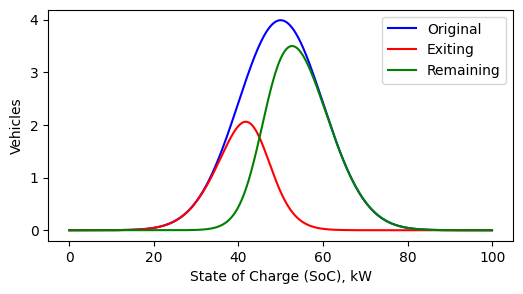

Skewness of Original Distribution: 1.1093658345458381
Kurtosis of Original Distribution: -0.31072287766129314
Skewness of Removed Distribution: 1.7884502033154055
Kurtosis of Removed Distribution: 1.7996532299873769
Skewness of Remaining Distribution: 1.520720276271305
Kurtosis of Remaining Distribution: 0.8174433289353877

 100 99.9999426758923 33.30263243534587 66.69731024054644


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon

def generate_vehicle_soc_density(mu_0, sigma, vehicle_count, bins):
    """Generates a continuous density function of vehicle SoC values."""
    bin_centers = (bins[:-1] + bins[1:]) / 2
    density = norm.pdf(bin_centers, mu_0, sigma)
    # Normalize to make the total area under the curve correspond to vehicle_count
    density *= vehicle_count
    return density

def calculate_removal_density(density, mu_c, k, bins):
    """Calculates the density of vehicles to be removed based on a continuous model."""
    bin_centers = (bins[:-1] + bins[1:]) / 2
    removal_probs = 1 / (1 + np.exp(k * (bin_centers - mu_c)))
    removal_density = density * removal_probs  # Expected density of removed vehicles
    remaining_density = density - removal_density  # Remaining density after removal
    return remaining_density, removal_density

def plot_continuous_distributions(bins, original_density, remaining_density, removed_density):
    """Plots the original, remaining, and removed vehicle SoC densities."""
    plt.figure(figsize=(6, 3))
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(bin_centers, original_density, label='Original', color='blue')
    plt.plot(bin_centers, removed_density, label='Exiting', color='red')
    plt.plot(bin_centers, remaining_density, label='Remaining', color='green')
    #plt.title('Vehicle SoC Distributions: Original, Remaining, and Removed')
    plt.xlabel('State of Charge (SoC), kW')
    plt.ylabel('Vehicles')
    plt.legend()
    plt.show()

# Parameters for a more continuous approach
mu_0 = 50  # Mean State of Charge
sigma = 10  # Standard deviation of SoC
mu_c = 45  # Cutoff State of Charge for conditional removal
veh_count = 100
k = 0.3  # Steepness parameter for the removal probability function
bins = np.linspace(0, 100, 1000)  # A finer binning for a more continuous representation

# Generate the original density function of vehicle SoC values
original_density = generate_vehicle_soc_density(mu_0, sigma, veh_count, bins)

# Calculate the densities for remaining and removed vehicles
remaining_density, removed_density = calculate_removal_density(original_density, mu_c, k, bins)

# Plot the continuous distributions
plot_continuous_distributions(bins, original_density, remaining_density, removed_density)

# Checking if distributions are Gaussian (not appropriate metrics as distributions are shifted)
from scipy.stats import norm, skew, kurtosis
print("Skewness of Original Distribution:", skew(original_density))
print("Kurtosis of Original Distribution:", kurtosis(original_density))
print("Skewness of Removed Distribution:", skew(removed_density))
print("Kurtosis of Removed Distribution:", kurtosis(removed_density))
print("Skewness of Remaining Distribution:", skew(remaining_density))
print("Kurtosis of Remaining Distribution:", kurtosis(remaining_density))

# Calculate the bin width
bin_width = bins[1] - bins[0]

print('\n', veh_count, 
      np.sum(original_density * bin_width),
      np.sum(removed_density * bin_width),
      np.sum(remaining_density * bin_width))